# Stochastic analysis of COVID19 time series in "Baden-Württemberg"
data as of 10.06.2020 by https://sozialministerium.baden-wuerttemberg.de/de/gesundheit-pflege/gesundheitsschutz/infektionsschutz-hygiene/informationen-zu-coronavirus/lage-in-baden-wuerttemberg/

algorithm from "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [43]:
import pandas as pd
import numpy as np
from scipy import signal
#import scipy.integrate as integrate
import matplotlib.pyplot as plt
import datetime

## 1. extract values from selected list
variables names: *I: Infected; *T: Deceased

In [14]:
filename = 'Tabelle_Coronavirus-Faelle-BW.xlsx'
dfi = pd.read_excel(filename, sheet_name='Infizierte Coronavirus in BW', header=None)
dft = pd.read_excel(filename, sheet_name='Todesfälle Coronavirus in BW', header=None)

In [15]:
ctyI = np.nan_to_num(np.asarray(dfi))
ctyT = np.nan_to_num(np.asarray(dft))
# row 7: dates
# row 8 to 51: regions
    # row 18: Freiburg
    # row 38: Ravensburg
# row 52: sum

### plot regional data

In [137]:
index = 17
region = ctyI[index][0]
title = 'Corona cases in %s' % region

# calculate x data: dates
# currently: approximation where each month is approximated by 30 days.
xI = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyI[6]]
xT = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyT[6]]

# calculate trajectory points from data of given index
yI = [el if type(el) == int else False for el in ctyI[index]]
yT = [el if type(el) == int else False for el in ctyT[index]]

# remove first element of lists (column of regions, only str in these)
del xI[0]
del xT[0]
del yI[0]
del yT[0]

# flip arrays
xI = np.flip(xI)
xT = np.flip(xT)
yI = np.flip(yI)
yT = np.flip(yT)

# Calculate new cases per day
dyIdt = np.diff(yI, prepend=0)
    
# Calculate new deaths per day
dyTt = np.diff(yT,prepend=0)

# Checking for mistakes
print('I1:', len(xI) == len(yI))
print('T1:', len(xT) == len(yT))
print('dIdt:', len(xI) == len(dyIdt))
print('dTdt:', len(xT) == len(dyTdt))
checksum = 0
for el in dyIdt:
    checksum += el
print("checksum I:", checksum == yI[-1])
checksum = 0
for el in dyTdt:
    checksum += el
print("checksum T:", checksum == yT[-1])

I1: True
T1: True
dIdt: True
dTdt: True
checksum I: True
checksum T: True


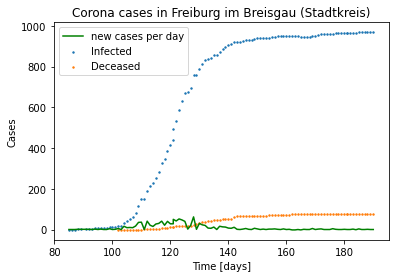

In [138]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI, label='Infected', s=2)
plt.scatter(xT, yT, label='Deceased', s=2)
plt.plot(xI, dyIdt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title(title)
plt.legend(loc='upper left')
plt.show()
#plt.savefig('%sCases.png' % region)

### plot total data

In [143]:
# calculation of x-data in cell above

# calculate total sum
yI_total = [el for el in ctyI[51]]
yT_total = [el for el in ctyT[51]]

# remove first element of lists (column of regions, only str in these)
del yI_total[0]
del yT_total[0]

# flip arrays
yI_total = np.flip(yI_total)
yT_total = np.flip(yT_total)

# Calculate new cases per day
dyI_totaldt = np.diff(yI_total, prepend=0)
    
# Calculate new deaths per day
dyT_totaldt = np.diff(yT_total, prepend=0)
    
# Checking for mistakes
print('I2:', len(xI) == len(yI_total))
print('T2:', len(xT) == len(yT_total))
print('dI_totaldt:', len(xI) == len(dyI_totaldt))
print('dT_totaldt:', len(xT) == len(dyT_totaldt))
checksum = 0
for el in dyI_totaldt:
    checksum += el
print("checksum I:", checksum == yI_total[-1])
checksum = 0
for el in dyT_totaldt:
    checksum += el
print("checksum T:", checksum == yT_total[-1])

I2: True
T2: True
dI_totaldt: True
dT_totaldt: True
checksum I: True
checksum T: True


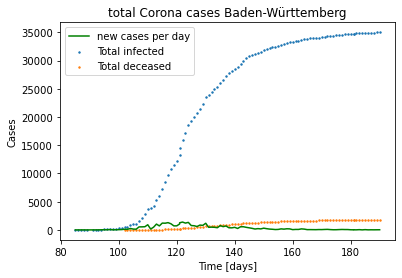

In [142]:
# Plot infected, deceased and new cases per day
plt.scatter(xI, yI_total, label='Total infected', s=2)
plt.scatter(xT, yT_total, label='Total deceased', s=2)
plt.plot(xI, dyI_totaldt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('BWCases.png')

## 2. stochastic analysis

### conditional probability function

In [184]:
def P_1(y, t):
    '''Probability Distribution function
    inherited from (9.54)[2]
    
    Calculates the probability distribution for Y_x having the value y
    at time t.
    '''
    # integrating y
    integrand = []
    for i in range(len(y)):
        integrand.append(np.sum(y[:i+1]))
    print(np.sum(y))
        
    # returning result
    result = integrand
    return result

def P_comp(y, t):
    '''Compound Probability function
    inherited from (9.55)[2]
    
    Takes y and t as lists of size n.
    '''
    pass

def P_cond(y, t, y_, t_):
    '''Conditional Probabilty function
    inherited from (9.58)[2]
    
    Conditional Probability is the probability-density for Y having at time t_2 the value y_2
    when at time t_1 the value y_1 was present.
    '''
    pass

35004
35004


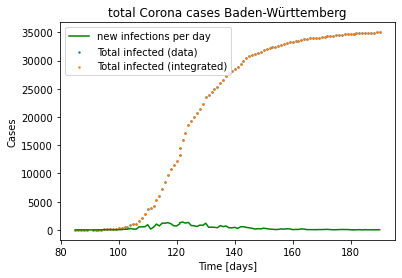

In [185]:
# Testing and plotting probability distribution function P_1
yI_total_integrated = P_1(dyI_totaldt, False)
print(yI_total_integrated[-1])

plt.scatter(xI, yI_total, label='Total infected (data)', s=2)
plt.scatter(xI, yI_total_integrated, label='Total infected (integrated)', s=2)
plt.plot(xI, dyI_totaldt, label='new infections per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend(loc='upper left')
plt.show()

### determine drift- and diffusion-coefficients

In [86]:
# eval parameter definition
tau = 0.01

def T_1(i, x, tau):
    pass
    
def T_2(i, j, x, tau):
    pass

def D_1(i, x):
    return T_1(i, x, tau)

def D_2(i, j, x):
    return T_2(i, j, x, tau) - tau * T_1(i, x, tau) * T_1(j, x, tau)

### resulting Fokker-Planck equation

## Literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020